In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# inon folders
data_base_path = ""
normal_dir = os.path.join(data_base_path, "all_crops")
IMG_DIR = os.path.join(data_base_path, "20260219_174631")


In [2]:
# Config & Paths
IMG_DIR = "C:\\Recovered\\BOAZ\\study\\projects\\samsung\\samsung_data"

IMAGE_SIZE = 50                                 # Good balance for simple CNN + speed
BATCH_SIZE = 256 # chat says 512-1024 might be possible
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_WORKERS = 4 if torch.cuda.is_available() else 0

# Make sure paths exist


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# 1. Define Transforms
# Normalization values are standard for ImageNet, but work well for most CNN tasks
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load Dataset from Folders
# This automatically maps the 10 folder names to integer labels
full_dataset = datasets.ImageFolder(root=str(IMG_DIR), transform=transform)

# Extract class mapping for future reference
classes = full_dataset.classes
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# 3. Stratified-style Split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# 4. Create DataLoaders
# Set to 256 as a safe start for your 1060 6GB; pin_memory=True speeds up GPU transfer
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Setup complete!")
print(f"Total images: {len(full_dataset)}")
print(f"Training: {len(train_dataset)} | Validation: {len(val_dataset)}")

✅ Found 10 classes: ['Broken Line', 'Corner', 'Edge False Color', 'Line Noise', 'Moire', 'Over Desaturation', 'Pattern artifact', 'Saturated False Color', 'Smears', 'Zagging']
✅ Setup complete!
Total images: 16390
Training: 13112 | Validation: 3278


In [4]:
class DistortionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row["filename"]

        image = Image.open(img_path).convert("RGB")

        label = int(row["label"])

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Model

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # in_channels, out_channels, stride, padding, dilation, group, bias
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # kernel_size=2, stride = kernel_size = 2, 128 → 64 → 32 → 16 → 8

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        # After 4 maxpools: 128//16 = 8 → 8x8x256
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64* 12 * 12, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Instantiate model
model = SimpleCNN(num_classes=len(classes)).to(device)
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Total parameters: 4,743,626


Input image: 3 × 128 × 128

After 4 blocks of conv + maxpool(2): spatial size is divided by 2 four times
128 ÷ 2 ÷ 2 ÷ 2 ÷ 2 = 8

Last conv layer had 256 filters → feature map size = 256 × 8 × 8

We need to turn this 3D tensor into 1D vector before Linear layer
→ nn.Flatten() does that

256 channels × 8 height × 8 width = 16384 numbers

First linear layer: 16384 → 512

Then dropout (randomly zero 50% of values during training → prevents overfitting)

Final linear: 512 → number of your classes

Classic VGG-style head.

In [6]:
# Loss, Optimizer & Scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [ ]:
train_losses, train_accs, test_accs = [], [], []

for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{50}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (pred == labels).sum().item()
        loop.set_postfix(loss=running_loss/len(train_loader))


    train_losses.append(running_loss/len(train_loader))
    train_accs.append(correct_train/total_train)


    model.eval()
    correct_test = 0





Epoch 24/50:   0%|          | 0/52 [00:15<?, ?it/s]


KeyboardInterrupt: 


📊 Accuracy of the model on the val images: 87.52%

📝 Classification Report:
                       precision    recall  f1-score   support

          Broken Line       0.88      0.92      0.90       836
               Corner       0.89      0.84      0.87        50
     Edge False Color       0.85      0.93      0.89       769
           Line Noise       1.00      0.58      0.74        24
                Moire       0.93      0.74      0.82       142
    Over Desaturation       0.90      0.91      0.90       563
     Pattern artifact       1.00      0.33      0.50         3
Saturated False Color       0.90      0.88      0.89       301
               Smears       0.85      0.78      0.82       544
              Zagging       0.96      0.48      0.64        46

             accuracy                           0.88      3278
            macro avg       0.92      0.74      0.80      3278
         weighted avg       0.88      0.88      0.87      3278



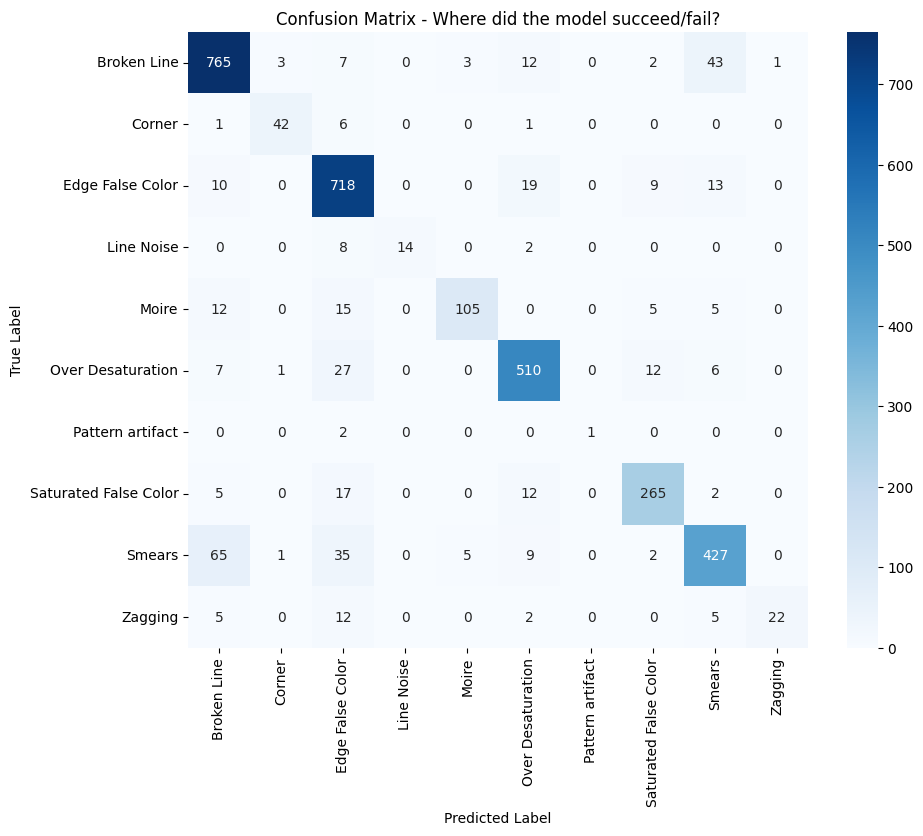

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # חישוב אחוז הדיוק
    accuracy = 100 * correct / total
    print(f'\n📊 Accuracy of the model on the val images: {accuracy:.2f}%')

    # הדפסת דוח מפורט (Precision, Recall, F1-score)
    print("\n📝 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # יצירת מטריצת בלבול ויזואלית
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Where did the model succeed/fail?')
    plt.show()

# הרצה של הפונקציה (וודא ש-val_loader ו-full_dataset קיימים)
# אם השתמשת ב-ImageFolder, השמות נמצאים ב-full_dataset.classes
evaluate_model(model, val_loader, device, full_dataset.classes)